## Background

We at HomeBuddy run a various number of AB tests to improve customer journey.
A big part of efforts is allocated to onboarding funnel, hence the main metrics are conversions throughout this funnel.
Usually we design multivariate tests with a few testing groups reflecting slightly different variations (often in terms of actual design) of the business hypothesis behind.
No matter how you run the experiments you want to get accurate and powerful procedure, that's why we use Dunnett's correction for all of the experiments that we have to maximize the power of AB engine.
Are you curious what it is?

### Prerequisites

It's expected that the reader has an experience with Python and it's main libraries for data analysis.
The actual notebook was written on Python 3.11.4 and to keep the results reproducible here is the list of particular packages that are being used in the article specified with their versions.

## Problem Definition

Imagine we want to optimize on onboarding funnel of an arbitrary product applying new business idea. 
We don't want to rely on expert assessment only and hence opt for design an AB test first.
The target metric is an abstruct conversion and we carry out a classical AB test with one treatment group.

It's not a secret that in such a scenario the best practice is a standard Z-test procedure for independant proportions

$$ Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}} \space\text{,where}\space P  = \frac{\hat{p}_1n_1 + \hat{p}_2n_2}{n_1 + n_2} $$

Under the conditions of the truth of the null hypothesis statistic follows standard normal distribution $$ Z \stackrel{H_0}{\sim} \mathbb{N}(0, 1) $$

There are multiple versions of calssical Z-test in Python and even though those have its unique selling points this time I apply my own implementation to stay consitent across this article using the same interface for all criteria.

In [205]:
import numpy as np

from scipy.stats import binom
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

from podlozhnyy_module.abtesting import Dunnett, Ztest

### Interface

As a brief check that the method is working as expected and to make you acquainted with its interface let's identify a dummy experiment

`input` must consist of at least three lists:

 - `base` is the basis event that stands as a denominator of conversion
 - `target` is the goal event - conversion numerator
 - `groups` are names of the experiment variants

In addition `variant` is specified to explicitly define which group we're focus on (it makes sense in case of multivariate testing)

In [206]:
input = {
    "base": [
        480,
        437,
    ],
    "target": [
        32,
        37,
    ],
    "groups": [
        "test",
        "control",
    ],
    "variant": "test",
}

Functionality is written leveraging well-known OOP principles, so the experiment is not a function that stands aside, but a class which besides `input` dictionary gets the keys of the corrresponding entities

In [207]:
test = Ztest(input, base="base", target="target", groups="groups", variant="variant")

In [208]:
print(f"p-value: {test.variant_pvalue(alternative='less'):.3f}, Z-statistic: {test.statistic[0]:.3f}")

p-value: 0.151, Z-statistic: -1.032


For on the fly verification, the results might be compared to the output of well known `statsmodels` package

In [209]:
count = input["target"]
nobs = input["base"]
stat, pval = proportions_ztest(count, nobs, alternative='smaller')
print('p-value: {0:0.3f}, Z-statistic: {1:0.3f}'.format(pval, stat))

p-value: 0.151, Z-statistic: -1.032


The numbers coincide and now we're ready to move to the main topic

In [24]:
test = Dunnett(input, 'PRELEADS', 'APPOINTMENTS', 'NAMES', 'EXPERIMENT_VARIANT')

In [25]:
test.results()

{'variant': ['v1927-1', 'v1927-2'],
 'statistic': array([[0.56082229],
        [0.67082215]]),
 'p-value': array([0.79714468, 0.72515713])}

In [26]:
test.variant_pvalue()

0.7971446759895714

In [27]:
input = {
  "APPOINTMENTS": [
    32,
    37,
  ],
  "EXPERIMENT_ID": "1259740289",
  "EXPERIMENT_VARIANT": "v1927-1",
  "LEADS": [
    480,
    437,
  ],
  "NAMES": [
    "Control",
    "v1927-1",
  ],
  "PRELEADS": [
    2256,
    2276,
  ]
}

In [28]:
test = Dunnett(input, 'LEADS', 'APPOINTMENTS', 'NAMES', 'EXPERIMENT_VARIANT')

In [29]:
test.results()

{'variant': ['v1927-1'],
 'statistic': array([[1.03159952]]),
 'p-value': 0.3025261338563313}

In [30]:
test.variant_pvalue(alternative = 'less')

0.8487369330718343

## Theory

While often basic Z-test procedure is the appropriate option for AB analysis, it's doesn't satisfy the genuine requirements for the statistical method when it comes to multiple hypothesis testing.
I hope you understand what is the problem in case of having $n$ independant metric in your test: if you set up acceptable Type I error rate $\alpha$ for each of them then the total probability to get at least one significant difference (dabbed as FWER) under the conditions of the truth of the null hypothesis (which means no difference between the groups by design) would be not $\alpha$ but $1 - (1 - \alpha)^n$ what totally invalidates the procedure.

There are two possible scenarious: either we have multiple metrics that we want to compare across the test and control group or we have several testing groups that apply different treatment to customers.
Whilst the first option is more popular by a wide margin and has lots of solutions, the second one is often undercovered in business industry and genrally the same procedures are used.
If you apply any type of corrections for multiple testing you're already ahead of 80% of teams that don't, although what I want to show you is that the second scenario must be treated differently to extract more insights from your experiments.

[Dunnet's test](https://en.wikipedia.org/wiki/Dunnett%27s_test) is a multiple comparison procedure developed specifically to compare each of a number of treatment groups to a control one, extended original [paper](https://www.jstor.org/stable/2528490?origin=crossref) was released in 1964. Dunnett's test is not a set aside procudure but more like an extension of monumental Student's T-test, for a specific design where every treatment group is compared to a single control one, what is leveraged to take into account the dependencies between comparisons. In case of proportions it's Z-test, as long as we don't need to estimate variance for binomial distribution in addition to the probability of success.

The main trick is to calculate variance in a different way, just to remind you in case of a standard procedure statistic looks like

$$ Z = \frac{\hat{p}_1 - \hat{p}_2}{S\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} $$

where $S$ is a standard error estimate comprises the squared root of variance of a combined sample $\sigma^2 = P(1 - P)$

Dunnett's test statictic looks exactly the same for every treatment group with the only difference laying under how variance is calculated.
In general in case of $n$ treatment groups and one control group $i=0$ of observations $(X_0, .. X_{N_i})$ with $N_i$ size of each, the formula is the following:
$$ S^{2} = \frac{\sum_{i=0}^{n}S_i^2}{df} = \frac{\sum_{i=0}^{n}\sum_{j=1}^{N_i}(X_{ij} - \bar{X_i})^2}{df} = \frac{\sum_{i=0}^{n}\sum_{j=1}^{N_i}X_{ij}^2 - n\bar{X_i}^2}{df} $$

where $df$ is degrees of freedom

$$ df = \sum_{i=0}^{n}N_{i} - (n + 1) $$

For proportions this "pooled" variance simplifies even further as long as the rest part of calculations is exactly the same

$$ S^{2} = \frac{\sum_{i=0}^{n}{N_i\bar{p_i}(1 - \bar{p_i})}}{df} $$

## Canonical AB test

First of all, to guarantee the accuracy we should challenge this specific criterion against a classical one in case when both of them are applicable - standard AB test.
What is good about proportions we can easily simulate the data in the blnik of an eye, so we're setting up a simulation and employ Monte Carlo process to check two things:

- correctness - the criterion should meet the identified confidence level, which means that in case of AA comparison we should get Type I error in $\alpha$ percent of experiments
- power - as it comes from the theory in case of only two groups Dunnett's test is equal to a classical Z-test, so shall we call the implementation out?

In addition to point estimate of False Positive Rate I offer to build 90% confidence interval to be more precise in the comparisons

In [210]:
def generate_sample(size: int, prob: float) -> int:
    """
    Return the number of target events
    """
    return binom(n=size, p=prob).rvs()

### Correctness in AA

In [13]:
np.random.seed(2024)

alpha = 0.05
n_iterations = 1000
p_general = 0.1

input = dict.fromkeys(["base", "target", "names", "variant"])
input["names"] = ["A", "B"]
input["variant"] = "B"

for size in map(int, [1e2, 1e3, 1e4]):

    dunnett_positives = 0
    z_positives = 0

    for i in range(n_iterations):

        input["base"] = [size, size]
        input["target"] = [generate_sample(size, p_general), generate_sample(size, p_general)]
        
        dunnett_test = Dunnett(input, "base", "target", "names", "variant")
        z_test = Ztest(input, "base", "target", "names", "variant")

        dunnett_p_value = dunnett_test.variant_pvalue(alternative="two-sided")
        z_p_value = z_test.variant_pvalue(alternative="two-sided")

        if dunnett_p_value <= alpha:
            dunnett_positives += 1
        if z_p_value <= alpha:
            z_positives += 1

    print(f'FPR for sample size {size}')
    
    l, r = proportion_confint(count=dunnett_positives, nobs=n_iterations, alpha=0.10, method='wilson')
    print(f'Dunnet: {dunnett_positives / n_iterations:.3f} ± {(r - l) / 2:.3f}')

    l, r = proportion_confint(count=z_positives, nobs=n_iterations, alpha=0.10, method='wilson')
    print(f'Z-test: {z_positives / n_iterations:.3f} ± {(r - l) / 2:.3f}')

    print()
    

FPR for sample size 100
Dunnet: 0.048 ± 0.011
Z-test: 0.048 ± 0.011

FPR for sample size 1000
Dunnet: 0.050 ± 0.011
Z-test: 0.050 ± 0.011

FPR for sample size 10000
Dunnet: 0.051 ± 0.011
Z-test: 0.051 ± 0.011



Amazing! It seems that 0.05 every time lies in the 90% confidence interval for FPR and hence the criterion is valid and moreover the numbers are exactly the same, it's what was expected and now let's check the power too

### Power in AB

In [55]:
np.random.seed(2024)

alpha = 0.05
n_iterations = 1000
p_general = 0.10
effect_size = 0.2

input = dict.fromkeys(["base", "target", "names", "variant"])
input["names"] = ["A", "B"]
input["variant"] = "B"

for size in map(int, [1e2, 1e3, 1e4]):

    dunnett_positives = 0
    z_positives = 0

    for i in range(n_iterations):

        input["base"] = [size, size]
        input["target"] = [generate_sample(size, p_general), generate_sample(size, p_general * (1 + effect_size))]
        
        dunnett_test = Dunnett(input, "base", "target", "names", "variant")
        z_test = Ztest(input, "base", "target", "names", "variant")

        dunnett_p_value = dunnett_test.variant_pvalue(alternative="two-sided")
        z_p_value = z_test.variant_pvalue(alternative="two-sided")

        if dunnett_p_value <= alpha:
            dunnett_positives += 1
        if z_p_value <= alpha:
            z_positives += 1

    print(f'TPR of {effect_size:.0%} effect size for sample size {size}')
    
    l, r = proportion_confint(count=dunnett_positives, nobs=n_iterations, alpha=0.10, method='wilson')
    print(f'Dunnet: {dunnett_positives / n_iterations:.3f} ± {(r - l) / 2:.3f}')

    l, r = proportion_confint(count=z_positives, nobs=n_iterations, alpha=0.10, method='wilson')
    print(f'Z-test: {z_positives / n_iterations:.3f} ± {(r - l) / 2:.3f}')

    print()
    

TPR of 20% effect size for sample size 100
Dunnet: 0.085 ± 0.015
Z-test: 0.085 ± 0.015

TPR of 20% effect size for sample size 1000
Dunnet: 0.306 ± 0.024
Z-test: 0.306 ± 0.024

TPR of 20% effect size for sample size 10000
Dunnet: 0.992 ± 0.005
Z-test: 0.992 ± 0.005



We are well on our way - the numbers are exactly the same, which means that in case of 2 groups Dunnett's test at least as powerful as a standard procedure. It's time to challenge it in a way it's supposed to be used: meet multivariate testing!

## Multivariate ABC

### Monte Carlo

Now we will track how the criterion controls not a single FPR, but family-wise error rate (FWER) and what is more in order to continue the comparison with a classical Z-test the latter needs to have bonferroni correction applied otherwise it wouldn't properly control FWER.

In [211]:
def fwe(x: np.ndarray, alpha: float) -> bool:
    """
    Indicates either at least one of null hypotheses is rejected
    """
    return max(x <= alpha)

In [212]:
def bonferroni_fwe(x: np.ndarray, alpha: float, n: int) -> bool:
    """
    Bonferroni correction for FWER, you can think of as it's Bonferroni-Holm procedure
    Because to have a False Positive result it's necessary and sufficient that at least one of `n` p-values doesn't exceed `alpha` / `n`
    """
    return fwe(x, alpha / n)

To simplify the code in the future Monte Carlo procedure is wrapped into a function with all the necessary parameters supplied as arguments

In [213]:
def monte_carlo(
    aa_test: bool = True,
    verbose: bool = True,
    n_iterations: int = 1000,
    group_size: int = 100,
    n_groups: int = 3,
    p_general: float = 0.1,
    effect_size: float = 0.2,
    alpha: float = 0.05,
) -> dict:

    input = dict.fromkeys(["base", "target", "names", "variant"])
    input["names"] = [chr(ord("A") + i) for i in range(n_groups)]
    input["variant"] = input["names"][-1]

    dunnett_positives = 0
    z_positives = 0

    for i in range(n_iterations):

        input["base"] = [group_size] * n_groups
        input["target"] = [generate_sample(group_size, p_general) for _ in range(n_groups - 1)]
        input["target"] += [generate_sample(group_size, p_general * (1 + effect_size * (1 - aa_test)))]

        dunnett_test = Dunnett(input, "base", "target", "names", "variant")
        z_test = Ztest(input, "base", "target", "names", "variant")

        dunnett_p_value = dunnett_test.groups_results(alternative="two-sided")["p-value"]
        z_p_value = z_test.groups_results(alternative="two-sided")["p-value"]

        if aa_test:
            if fwe(dunnett_p_value, alpha):
                dunnett_positives += 1
            if bonferroni_fwe(z_p_value, alpha, 2):
                z_positives += 1
        else:
            if isinstance(dunnett_p_value, np.ndarray) and dunnett_p_value[-1] <= alpha:
                dunnett_positives += 1
            elif isinstance(dunnett_p_value, np.float64) and dunnett_p_value <= alpha:
                dunnett_positives += 1
            if sidak_holm(z_p_value, alpha)[-1]:
                z_positives += 1
            
    dl, dr = proportion_confint(count=dunnett_positives, nobs=n_iterations, alpha=0.10, method='wilson')
    zl, zr = proportion_confint(count=z_positives, nobs=n_iterations, alpha=0.10, method='wilson')

    if verbose:
        print (
            f"{'FPR' if aa_test else f'TPR of {effect_size:.0%} effect size'} for sample size {group_size}\n"
            f" - Dunnett: {dunnett_positives / n_iterations:.3f} ± {(dr - dl) / 2:.3f}\n"
            f" - Z-Test: {z_positives / n_iterations:.3f} ± {(zr - zl) / 2:.3f}\n"
        )
    return {"dunnett": [dl, dunnett_positives / n_iterations, dr], "z-test": [zl, z_positives / n_iterations, zr]}

### Correctness

Validity first, let's check the ability to control FWER at predefined $\alpha$ level

In [17]:
np.random.seed(2024)

for size in [1e2, 5e2, 1e3, 5e3]:
    _ = monte_carlo(aa_test=True, group_size=int(size))

FPR for sample size 100
 - Dunnett: 0.045 ± 0.011
 - Z-Test: 0.042 ± 0.010

FPR for sample size 500
 - Dunnett: 0.048 ± 0.011
 - Z-Test: 0.045 ± 0.011

FPR for sample size 1000
 - Dunnett: 0.063 ± 0.013
 - Z-Test: 0.056 ± 0.012

FPR for sample size 5000
 - Dunnett: 0.050 ± 0.011
 - Z-Test: 0.046 ± 0.011



Super cool, both methods: Dunnett's Test without any corrections and Z-Test with Bonferroni-Holm correction control FWER correctly

### Power

Now it's the time to define a full fledged step-down procedure for multivariate testing as although its shortened version works well to define FWER it doesn't when it comes to a power analysis.
I prefer Sidak-Holm procedure as it's known as the most powerful prodecure that controls FWER however as long as sample size is increased the difference from Bonferroni-Holm hardly noticeable.

In [214]:
def sidak_holm(p_values: np.ndarray, alpha: float) -> np.ndarray:
    """
    Step down Sidak-Holm procedure
    If the statistics are jointly independent, no procedure can be constructed to control FWER that is more powerful than the Sidak-Holm method
    """
    m = p_values.size
    adjusted_alpha = np.array([1 - (1 - alpha) ** (1 / (m - i + 1)) for i in range(1, m + 1)])
    sorted_indexes = np.argsort(p_values)
    sorted_pvalues = p_values[sorted_indexes]
    first_reject = (list(sorted_pvalues <= adjusted_alpha) + [False]).index(False)
    result = np.array([True] * first_reject + [False] * (m - first_reject))
    return result[np.argsort(sorted_indexes)]

For the power test I suggest to use two treatment groups and a single control where in one of the treatment an effect of 20% uplift added. So the null hypothesis should be rejected and True Positive Rate is measured - is the share of rejected hypotheses among number of iterations.

In [24]:
np.random.seed(2024)

for size in [1e2, 5e2, 1e3, 5e3]:
    _ = monte_carlo(aa_test=False, group_size=int(size))

TPR of 20% effect size for sample size 100
 - Dunnett: 0.051 ± 0.011
 - Z-Test: 0.043 ± 0.011

TPR of 20% effect size for sample size 500
 - Dunnett: 0.104 ± 0.016
 - Z-Test: 0.092 ± 0.015

TPR of 20% effect size for sample size 1000
 - Dunnett: 0.265 ± 0.023
 - Z-Test: 0.240 ± 0.022

TPR of 20% effect size for sample size 5000
 - Dunnett: 0.855 ± 0.018
 - Z-Test: 0.842 ± 0.019



The results are promising! The power of Dunnett's test is every time exceeds the power of Z-test with Sidak-Holm procedure applied.
The difference is not significant though, so we can't say for sure that it's better, let's experiment more with parameters and change `effect_size`.

In [26]:
np.random.seed(2024)

for effect_size in [0.1, 0.2, 0.3]:
    _ = monte_carlo(aa_test=False, group_size=3000, effect_size=effect_size)

TPR of 10% effect size for sample size 3000
 - Dunnett: 0.163 ± 0.019
 - Z-Test: 0.157 ± 0.019

TPR of 20% effect size for sample size 3000
 - Dunnett: 0.589 ± 0.026
 - Z-Test: 0.569 ± 0.026

TPR of 30% effect size for sample size 3000
 - Dunnett: 0.927 ± 0.014
 - Z-Test: 0.914 ± 0.015



Exciting, the result remains the same, and if we know that Sidak-Holm is the most powerful method that controls FWER for the general use case, we see now that Dunnett's at least not worse. Finally, the most appealing variable is the number of treatment groups, let's vary it too.

In [28]:
np.random.seed(2024)

for n_groups in [3, 5, 7]:
    _ = monte_carlo(aa_test=False, group_size=3000, n_groups=n_groups)

TPR of 20% effect size for sample size 3000
 - Dunnett: 0.608 ± 0.025
 - Z-Test: 0.601 ± 0.025

TPR of 20% effect size for sample size 3000
 - Dunnett: 0.544 ± 0.026
 - Z-Test: 0.506 ± 0.026

TPR of 20% effect size for sample size 3000
 - Dunnett: 0.464 ± 0.026
 - Z-Test: 0.424 ± 0.026



Now we've nailed it! The number of groups is what affects the bottom line. The more groups are in the experiment - the more powerful Dunnett's Correction than Sidak-Holm.
So, let's build a title image for this article that illustrates how Dunnett's test outperforms the well-known step-down procedure as the number of treatment groups increases.

In [191]:
np.random.seed(2024)
ztest_values = []
dunnett_values = []

for n_groups in range(2, 16):
    result = monte_carlo(aa_test=False, verbose=False, group_size=3000, n_groups=n_groups)
    dunnett_values.append(result["dunnett"])
    ztest_values.append(result["z-test"])

In [192]:
import plotly.express as px

colors_list = px.colors.qualitative.Plotly

def hex2rgba(hex, alpha):
    """
    Convert plotly hex colors to rgb and enables transparency adjustment
    """
    col_hex = hex.lstrip('#')
    col_rgb = list(int(col_hex[i:i+2], 16) for i in (0, 2, 4))
    col_rgb.extend([alpha])
    return tuple(col_rgb)

rgba_colors = [hex2rgba(color, alpha=0.5) for color in colors_list]

colors = ['rgba' + str(rgba) for rgba in rgba_colors]

def get_new_color(colors):
    while True:
        for color in colors:
            yield color

palette = get_new_color(colors)

In [193]:
import plotly.graph_objs as go

def add_chart(figure, data, title):

    x = list(range(1, 15))
    color = next(palette)
    
    figure.add_trace(
        go.Scatter(
            name=title,
            x=x,
            y=[v[1] for v in data],
            mode='lines',
            line=dict(color=color),
        ),
    )
    figure.add_trace(
        go.Scatter(
            name='Upper Bound',
            x=x,
            y=[v[2] for v in data],
            mode='lines',
            line=dict(width=0),
            marker=dict(color="#444"),
            hovertemplate="%{y:.3f}",
            showlegend=False,
        ),
    )
    figure.add_trace(
        go.Scatter(
            name='Lower Bound',
            x=x,
            y=[v[0] for v in data],
            mode='lines',
            line=dict(width=0),
            marker=dict(color="#444"),            
            hovertemplate="%{y:.3f}",
            showlegend=False,
            fillcolor=color,
            fill='tonexty',
        ),
    )

In [197]:
figure = go.Figure()

add_chart(figure, dunnett_values, "Dunnnett's Correction")

add_chart(figure, ztest_values, 'Z-Test with Sidak-Holm')

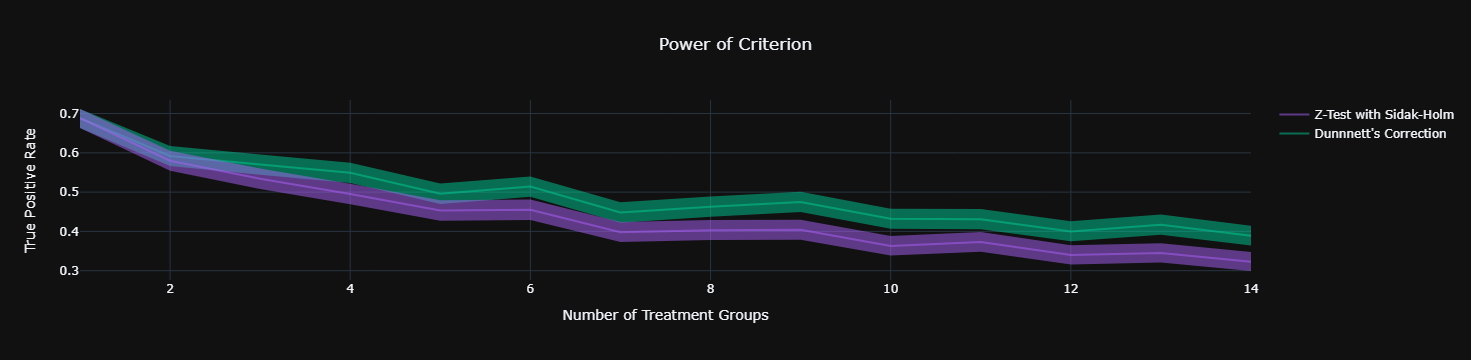

In [198]:
figure.update_xaxes(
    title_text="Number of Treatment Groups"
)

figure.update_layout(
    yaxis_title='True Positive Rate',
    title={
        "x": 0.5,
        "text": 'Power of Сriterion',
    },
    hovermode="x",
    template="plotly_dark",
)

figure.show()

## Conclusion

It was shown that when the experiment design satisfies the premises of Dunnett's Test applicability (only $n$ comparisons of $n$ test groups against a single control) at least in a specific case of conversion metrics, Dunnett's Correction is more powerful that the standard step-down procedures like Sidak-Holm.

While Dunnet's correction is a definite winner it doesn't mean that Sidak-Holm is abandoned from now on inour team, the proper design would be to use Dunnett's Correction first for multivariate testing and Sidak-Holm procedure must be applied on top if there are multiple metrics to compare between the groups, which is often the case.

## Additional Information


 1. [Original Paper from Journal of the American Statistical Association](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1955.10501294?journalCode=uasa20)
 2. [Multivariate Testing - Best Practices](https://blog.analytics-toolkit.com/2017/multivariate-testing-practices-tools-mvt-abn-tests/)
 3. [Dunnett's Correction in Analytics ToolKit](https://www.analytics-toolkit.com/glossary/dunnett%E2%80%99s-correction/)
 4. [Multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)